 [!IMPORTANT]
 You will need an [.NET 8 SDK](https://dotnet.microsoft.com/en-us/download/dotnet/8.0) and [Polyglot](https://marketplace.visualstudio.com/items?itemName=ms-dotnettools.dotnet-interactive-vscode) to get started with this notebook using .NET Interactive.

# Introduction to Semantic Kernel in .NET

Welcome to this introduction to Semantic Kernel using .NET! This notebook will guide you through the basic concepts of Semantic Kernel and show you how to implement them using C#.

## What You'll Learn
- What Semantic Kernel is and how it works
- Setting up a kernel with Azure OpenAI
- Creating and using semantic functions and plugins
- Working with native functions
- Integrating AI services with your applications

Semantic Kernel is a lightweight SDK that integrates Large Language Models (LLMs) with conventional programming languages. It enables you to build AI-first applications while still leveraging your existing code and systems.

## 1. Setting Up Your Environment

To use Semantic Kernel in a .NET environment, you'll need to install the required NuGet packages. The following cell will install the core packages needed for this notebook.

In [46]:
#r "nuget: Microsoft.SemanticKernel"
#r "nuget: Microsoft.SemanticKernel.Connectors.AzureOpenAI"
#r "nuget: Microsoft.SemanticKernel.Agents.Core"
#r "nuget: Microsoft.Extensions.Configuration"
#r "nuget: Microsoft.Extensions.Configuration.Json" 
#r "nuget: Microsoft.Extensions.Configuration.EnvironmentVariables" 
#r "nuget: Microsoft.Extensions.Configuration.Binder" 

Installed Packages Microsoft.Extensions.Configuration, 9.0.9 Microsoft.Extensions.Configuration.Binder, 9.0.9 Microsoft.Extensions.Configuration.EnvironmentVariables, 9.0.9 Microsoft.Extensions.Configuration.Json, 9.0.9 Microsoft.SemanticKernel, 1.65.0 Microsoft.SemanticKernel.Agents.Core, 1.65.0 Microsoft.SemanticKernel.Connectors.AzureOpenAI, 1.65.0

### Setting up credentials

To use Azure OpenAI services, we'll need to configure our credentials. In a real application, you would typically store these in a configuration file or environment variables, but for this notebook, we'll define them directly.

You'll need to provide:
- Azure OpenAI Endpoint
- API Key
- Deployment Name

In [47]:
// Load necessary namespaces
using System;
using System.IO;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.Extensions.Configuration;

// Define a simple settings class for Azure OpenAI
public class AzureOpenAISettings
{
    public string Endpoint { get; set; } = string.Empty;
    public string ModelDeploymentName { get; set; } = string.Empty;
    public string ApiKey { get; set; } = string.Empty;
}

// Find and load settings from appsettings.json
var azureOpenAISettings = new AzureOpenAISettings();
var foundSettings = false;

// Search for appsettings.json in current directory and parent directories
string projectDirectory = Directory.GetCurrentDirectory();
while (!string.IsNullOrEmpty(projectDirectory))
{
    // Check for appsettings.json directly or in src subfolder
    string[] possiblePaths = new[] { 
        Path.Combine(projectDirectory, "appsettings.json"),
        Path.Combine(projectDirectory, "src", "appsettings.json")
    };
    
    foreach (var path in possiblePaths)
    {
        if (File.Exists(path))
        {
            Console.WriteLine($"Found appsettings.json at: {path}");
            
            var configuration = new ConfigurationBuilder()
                .AddJsonFile(path)
                .Build();
            
            // Try to extract settings from AzureOpenAISettings or AzureOpenAI section
            var section = configuration.GetSection("AzureOpenAISettings");
            if (!section.Exists())
                section = configuration.GetSection("AzureOpenAI");
                
            if (section.Exists())
            {
                azureOpenAISettings.Endpoint = section["Endpoint"] ?? string.Empty;
                azureOpenAISettings.ApiKey = section["ApiKey"] ?? string.Empty;
                azureOpenAISettings.ModelDeploymentName = section["ModelDeploymentName"] ?? string.Empty;
                foundSettings = true;
                break;
            }
        }
    }
    
    if (foundSettings)
        break;
        
    // Move up to parent directory
    projectDirectory = Directory.GetParent(projectDirectory)?.FullName;
}

Found appsettings.json at: c:\Users\shenglinxu\OneDrive - Microsoft\projects\VGZ\dotnet_agents_demo_sk\src\appsettings.json


In [48]:
// Check if we have valid settings
if (foundSettings && 
    !string.IsNullOrEmpty(azureOpenAISettings.Endpoint) && 
    !string.IsNullOrEmpty(azureOpenAISettings.ApiKey) &&
    !string.IsNullOrEmpty(azureOpenAISettings.ModelDeploymentName))
{
    Console.WriteLine("✅ Successfully loaded settings from appsettings.json!");
    Console.WriteLine($"Azure OpenAI Endpoint: {azureOpenAISettings.Endpoint}");
    Console.WriteLine($"Model Deployment: {azureOpenAISettings.ModelDeploymentName}");
}
else
{
    Console.WriteLine("⚠️ Couldn't load valid settings from appsettings.json");
    Console.WriteLine("Please manually configure the settings below.");
    
    // Set placeholder values
    azureOpenAISettings.Endpoint = "https://your-endpoint.openai.azure.com/";
    azureOpenAISettings.ApiKey = "your-api-key"; 
    azureOpenAISettings.ModelDeploymentName = "your-deployment-name";
}

✅ Successfully loaded settings from appsettings.json!
Azure OpenAI Endpoint: https://vgz-foundry-demo-foundry.openai.azure.com/
Azure OpenAI Endpoint: https://vgz-foundry-demo-foundry.openai.azure.com/
Model Deployment: o4-mini
Model Deployment: o4-mini


## 2. Basic Semantic Kernel Concepts

Semantic Kernel consists of several core components:

1. **Kernel**: The central orchestration unit that connects AI services, plugins, and functions
2. **AI Services**: Integrations with LLMs like Azure OpenAI or OpenAI
3. **Plugins**: Collections of functions (both native and semantic)
4. **Functions**: The building blocks of functionality (semantic and native)
5. **Agents**: Higher-level abstractions that can use functions to solve complex problems

### The Kernel

The Kernel is the central orchestration component in Semantic Kernel. It:

- Manages AI services and plugins
- Provides function execution capabilities
- Handles the communication between your application and LLMs
- Routes function calls to the appropriate implementation

Let's create our first Kernel:

In [49]:
// Create a Kernel Builder
var kernelBuilder = Kernel.CreateBuilder();

// Add Azure OpenAI Chat Completion service
kernelBuilder.Services.AddAzureOpenAIChatCompletion(
    deploymentName: azureOpenAISettings.ModelDeploymentName,
    endpoint: azureOpenAISettings.Endpoint,
    apiKey: azureOpenAISettings.ApiKey,
    serviceId: "chat-completion"
);

// Build the kernel
var kernel = kernelBuilder.Build();

Console.WriteLine("Kernel created successfully!");

Kernel created successfully!


### Understanding Service Configuration

When adding an AI service to the kernel, we specified a `service_id`. This ID is important because:

1. It allows you to add multiple services to the same kernel
2. You can selectively use different services for different agents
3. It helps organize and identify your services

If you need specific execution settings for your AI service (like temperature, top-p, or function calling behavior), you can retrieve and modify them:

In [50]:
using System;
using Microsoft.SemanticKernel.Agents;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.AzureOpenAI;

// Get the execution settings for our service
var executionSettings = new AzureOpenAIPromptExecutionSettings
{
    ServiceId = "chat-completion",
    FunctionChoiceBehavior = FunctionChoiceBehavior.Auto(),
    Temperature = 0.7
};


// You can use these settings when creating a function or when invoking the AI
Console.WriteLine($"Configured execution settings with temperature: {executionSettings.Temperature}");

Configured execution settings with temperature: 0.7


## 3. Your First Agent: ChatCompletionAgent

Now that we have our kernel and services set up, let's create our first agent. We'll start with the `ChatCompletionAgent`, which is a simple yet powerful agent that leverages the chat completion capabilities of large language models.

### Creating a Basic Agent

To create a `ChatCompletionAgent`, we need to provide:
1. A kernel with a configured chat service
2. Instructions that define the agent's behavior
3. Optional parameters like a name and execution settings

Let's create a simple assistant agent:

In [51]:
ChatCompletionAgent assistantAgent =
    new()
    {
        Name = "Assistant",
        Instructions = "You are a helpful assistant that provides concise and accurate information. Keep your responses brief but informative.",
        Kernel = kernel
    };

### Configuring Instructions and Parameters

The `instructions` parameter is crucial as it defines how your agent will behave. Think of it as the "system prompt" that shapes the agent's personality, capabilities, and limitations. Let's explore some more complex instructions:

In [52]:
// Create a specialized Math Tutor agent
var mathTutorAgent = new ChatCompletionAgent()
{
    Kernel = kernel,
    Name = "MathTutor",
    Instructions = @"You are a math tutor specialized in helping students understand mathematical concepts.
    
    When responding to questions:
    1. First explain the underlying concept in simple terms
    2. Then walk through the solution step by step
    3. Provide a simple example to reinforce the learning
    4. Avoid solving problems directly without explanation
    
    Always be encouraging and patient."
};

Console.WriteLine($"Agent '{mathTutorAgent.Name}' created with specialized instructions.");


Agent 'MathTutor' created with specialized instructions.


### Understanding Agent Execution

Once an agent is created, it needs a chat history to interact with. The chat history maintains the state of the conversation and provides context for the agent's responses.

Here's a simple example of how to execute an agent:

In [53]:
// Create a chat history to maintain conversation state
var chatHistory = new ChatHistory();

// Add a user message to the chat history
chatHistory.AddUserMessage("Hello! Can you introduce yourself?");

// Define a function to collect agent responses
async Task<string> GetAgentResponseAsync(ChatCompletionAgent agent, ChatHistory history)
{
    // Use InvokeAsync and collect the response content
    var responseBuilder = new System.Text.StringBuilder();
    
    await foreach (var item in agent.InvokeAsync(history))
    {
        if (item.Message is ChatMessageContent content)
        {
            responseBuilder.Append(content.Content);
        }
    }
    
    return responseBuilder.ToString();
}

// Execute the agent and get the response
var responseText = await GetAgentResponseAsync(mathTutorAgent, chatHistory);

// Print the agent's response
Console.WriteLine($"Agent: {responseText}");

// Add the response to the chat history for continuity
chatHistory.AddAssistantMessage(responseText);

Agent: Hello there! I’m your friendly math tutor, here to help you build confidence and understanding in mathematics. Here’s a bit about how I work:

1. I explain each concept in simple, clear terms so you see the “why” behind the math.  
2. I guide you step by step through problems rather than just giving you answers.  
3. I reinforce learning with straightforward examples you can follow.  
4. I’m always patient and encouraging—there are no “silly” questions!

Feel free to tell me what topic you’re working on or any specific questions you have, and we’ll tackle them together.


### Exercise: Implement a Simple Question-Answering Agent

Now it's your turn to create a custom agent. Implement a question-answering agent that specializes in providing factual information about a specific topic of your choice.

Your task:
1. Create a new `ChatCompletionAgent` with a descriptive name
2. Configure it with detailed instructions that define its area of expertise and how it should respond
3. Create a chat history with a relevant question
4. Execute the agent and display its response

In [ ]:
// Your code here to create and execute a question-answering agent
// feel free to use the following template:     
    // Name = "SpaceExpert",
    // Instructions = @"You are an expert in astronomy and space exploration.
    // When answering questions:
    // - Provide factual, scientifically accurate information
    // - Include relevant dates, measurements, and statistics when applicable
    // - Explain complex concepts in accessible language
    // - Differentiate between established facts and theoretical or speculative ideas
    // - When appropriate, mention recent developments or missions
    // Focus on being educational and inspiring curiosity about space."

// 1. Create your agent with specialized instructions

// 2. Create a chat history with a relevant question

// 3. Execute the agent and get its response

// 4. Print the response

<details>
<summary>Click to see solution</summary>

```c#
// Create a specialized space expert agent
var spaceExpertAgent = new ChatCompletionAgent()
{
    Kernel = kernel,
    Name = "SpaceExpert",
    Instructions = @"You are an expert in astronomy and space exploration.
    
    When answering questions:
    - Provide factual, scientifically accurate information
    - Include relevant dates, measurements, and statistics when applicable
    - Explain complex concepts in accessible language
    - Differentiate between established facts and theoretical or speculative ideas
    - When appropriate, mention recent developments or missions
    
    Focus on being educational and inspiring curiosity about space."
};

// Create a chat history with a specific astronomy question
var spaceChat = new ChatHistory();
spaceChat.AddUserMessage("What are exoplanets and how do scientists detect them?");

// Helper function to get the agent's response
async Task<string> GetExpertResponseAsync(ChatCompletionAgent agent, ChatHistory history)
{
    // Use InvokeAsync and collect the response content
    var responseBuilder = new System.Text.StringBuilder();
    
    await foreach (var item in agent.InvokeAsync(history))
    {
        if (item.Message is ChatMessageContent content)
        {
            responseBuilder.Append(content.Content);
        }
    }
    
    return responseBuilder.ToString();
}

// Execute the agent and get its response
var spaceResponse = await GetExpertResponseAsync(spaceExpertAgent, spaceChat);

// Display the agent's response
Console.WriteLine($"SpaceExpert: {spaceResponse}");
```
</details>

### Key Takeaways

In this section, we've learned how to:

1. **Create a basic `ChatCompletionAgent`** with specific instructions
2. **Configure agent instructions** to define specialized behavior
3. **Use template parameters** in instructions for dynamic behavior
4. **Execute agents** using different invocation methods

In the next section, we'll explore more complex interactions with agents, including multi-turn conversations.

## 4. Basic Agent Interactions

Now that we've created agents, let's explore how to interact with them in a more conversational way. This involves understanding chat history, adding messages, and processing responses over multiple turns.

### Chat History Fundamentals

The `ChatHistory` class is fundamental to agent interactions. It:
- Maintains the chronological sequence of messages in a conversation
- Provides context for the agent to generate relevant responses
- Allows for multi-turn conversations with memory of previous exchanges

Let's create a new chat history and explore its basic functionality:

In [54]:
// Create a new chat history
var chat = new ChatHistory();

// Add system message (optional but useful for setting global context)
chat.AddSystemMessage("This is a conversation between a user and an AI assistant.");

// Add user message
chat.AddUserMessage("Hello, I have some questions about programming.");

// Print the chat history
Console.WriteLine("Chat history:");
// Using chat directly as it's an IEnumerable of AuthorRole
foreach (var message in chat)
{
    Console.WriteLine($"{message.Role}: {message.Content}");
}

Chat history:
system: This is a conversation between a user and an AI assistant.
user: Hello, I have some questions about programming.


### Processing Agent Responses

When an agent generates a response, it's important to add it back to the chat history to maintain the conversation flow. Let's see how to do this in a multi-turn conversation:

In [55]:
// Create a function to handle a multi-turn conversation
public static async Task HaveConversation(ChatCompletionAgent agent, ChatHistory chatHistory, List<string> userMessages)
{
    foreach (string message in userMessages)
    {
        // Add the user message to chat history
        chatHistory.AddUserMessage(message);
        
        Console.WriteLine($"User: {message}");
        
        // Get the agent's response using InvokeAsync
        string agentResponse = "";
        await foreach (var item in agent.InvokeAsync(chatHistory))
        {
            if (item.Message is ChatMessageContent content)
            {
                agentResponse += content.Content;
            }
        }
        
        // Add the agent's response to chat history
        chatHistory.AddAssistantMessage(agentResponse);
        Console.WriteLine($"Agent: {agentResponse}");
    }
    
    // Print the chat history
    Console.WriteLine("Chat history:");
    // Using chat directly as it implements IEnumerable
    foreach (var message in chatHistory)
    {
        Console.WriteLine($"{message.Role}: {message.Content}");
    }
}


// Create a fresh chat history
var programmingChat = new ChatHistory();

// List of user messages for a multi-turn conversation
var userMessages = new List<string>
{
    "What is Python used for?",
    "How does it compare to Java?",
    "What would you recommend for a beginner to learn first?"
};

// Create a programming tutor agent
var programmingTutor = new ChatCompletionAgent()
{
    Kernel = kernel,
    Name = "ProgrammingTutor",
    Instructions = "You are an experienced programming tutor who explains concepts clearly and concisely. Make your answers very concise.",
};

// Have a conversation
await HaveConversation(programmingTutor, programmingChat, userMessages);

User: What is Python used for?
Agent: Python is a general-purpose, high-level language used for:

- Web development (Django, Flask)  
- Data analysis & visualization (pandas, NumPy, matplotlib)  
- Machine learning & AI (scikit-learn, TensorFlow, PyTorch)  
- Scripting & automation (batch jobs, file ops)  
- Desktop GUIs (Tkinter, PyQt)  
- Game development (Pygame)  
- Networking & APIs  
- Embedded/IoT projects (MicroPython)  
- Teaching programming and rapid prototyping
User: How does it compare to Java?
Agent: Here’s a concise comparison:

• Typing  
  – Python: dynamically typed, no declarations  
  – Java: statically typed, explicit types  

• Syntax & Readability  
  – Python: concise, indentation-based  
  – Java: more boilerplate (semicolons, braces)  

• Performance  
  – Python: slower interpreter, C-powered libs mitigate  
  – Java: faster JIT-compiled bytecode on JVM  

• Ecosystem & Use Cases  
  – Python: data science, scripting, web apps, ML  
  – Java: large-scale ente

## 5. Function Calling and Plugins

One of the most powerful features of Semantic Kernel agents is their ability to use plugins and call functions. This enables agents to go beyond just generating text and actually perform actions, retrieve information, and integrate with external systems.

### What are Plugins in Semantic Kernel?

In Semantic Kernel, a **plugin** is a collection of related functions that can be registered with the kernel and made available to agents. Plugins can:
- Retrieve information from databases or APIs
- Perform calculations or data transformations
- Execute system operations
- Interact with external services

Plugins contain one or more **functions**, which can be:
1. **Native Functions**: Written in code (Python) that execute when called
2. **Semantic Functions**: Defined by prompts that are sent to the LLM when called

Let's create a simple plugin with native functions to demonstrate how this works.

In [56]:
using System.ComponentModel;

// Define a simple temperature conversion tool
public class TemperatureConverter
{
    // Define a kernel function to convert Celsius to Fahrenheit
    [KernelFunction, Description("Converts temperature from Celsius to Fahrenheit")]
    public string CelsiusToFahrenheit(
        [Description("Temperature in Celsius")] double celsius)
    {
        double fahrenheit = (celsius * 9 / 5) + 32;
        return $"{celsius}°C is equal to {fahrenheit:F1}°F";
    }

    // Define a kernel function to convert Fahrenheit to Celsius
    [KernelFunction, Description("Converts temperature from Fahrenheit to Celsius")]
    public string FahrenheitToCelsius(
        [Description("Temperature in Fahrenheit")] double fahrenheit)
    {
        double celsius = (fahrenheit - 32) * 5 / 9;
        return $"{fahrenheit}°F is equal to {celsius:F1}°C";
    }
}

// Import the temperature converter as a plugin
var temperatureTool = kernel.ImportPluginFromObject(new TemperatureConverter(), "TemperatureTool");

In [57]:
// Create a chat history
var chatHistory = new ChatHistory();

// Define the settings for the Azure OpenAI service
var settings = new AzureOpenAIPromptExecutionSettings
{
    ServiceId = "chat-completion",
    FunctionChoiceBehavior = FunctionChoiceBehavior.Auto()
};

// Create an agent that can use the temperature tool
var weatherAgent = new ChatCompletionAgent() {
    Kernel = kernel,
    Name = "HelperAgent",
    Instructions = "You are a helpful weather assistant. When asked about temperature conversions, use the TemperatureTool functions to perform accurate calculations.",
    Arguments = new KernelArguments(settings)
};

// Add a user question to the chat
chatHistory.AddUserMessage("Can you convert 25 degrees Celsius to Fahrenheit?");

// Get the agent's response using InvokeAsync
string agentResponse = "";
await foreach (var item in weatherAgent.InvokeAsync(chatHistory))
{
    if (item.Message is ChatMessageContent content)
    {
        agentResponse += content.Content;
    }
}
// Output the result
Console.WriteLine($"Agent: {agentResponse}");

Agent: 25 degrees Celsius is equal to 77.0 degrees Fahrenheit.


### Exercise: Create Your Own Agent with a Plugin

Remember the MathTutor Agent we made earlier? Try adding a plugin to it. 

In [ ]:
using System.ComponentModel;

// Define a unit conversion tool to enhance our math tutor agent
public class UnitConverter
{
    // Kilograms to Pounds conversion function
    [KernelFunction, Description("Converts weight from kilograms to pounds")]
    public string KilogramsToPounds(
        [Description("Weight in kilograms")] double kilograms)
    {
        // 1 kg is approximately 2.20462 pounds
        double pounds = kilograms * 2.20462;
        return $"{kilograms} kg is equal to {pounds:F2} lbs";
    }
    
    // Pounds to Kilograms conversion function
    [KernelFunction, Description("Converts weight from pounds to kilograms")]
    public string PoundsToKilograms(
        [Description("Weight in pounds")] double pounds)
    {
        // 1 pound is approximately 0.453592 kg
        double kilograms = pounds * 0.453592;
        return $"{pounds} lbs is equal to {kilograms:F2} kg";
    }
}

var math_kernel = kernel.Clone();

// Import the unit converter as a plugin

// Create a math tutor agent that can use both the temperature tool and unit converter

// Create a chat history for our math tutoring session

// Add a user question about unit conversion

// Get the math tutor agent's response

// Output the result

<details>
<summary>Click to see solution</summary>

```c#
math_kernel.ImportPluginFromObject(new UnitConverter(), "UnitConverter");

// Create a math tutor agent that can use both the temperature tool and unit converter
var mathTutorWithTools = new ChatCompletionAgent() {
    Kernel = kernel,
    Name = "MathTutorWithTools",
    Instructions = @"You are a math tutor specialized in helping students understand mathematical concepts.
    
    When responding to questions:
    1. First explain the underlying concept in simple terms
    2. Then walk through the solution step by step
    3. When dealing with unit conversions, use the appropriate tools
    4. Show your work and explain each calculation
    5. Provide a simple example to reinforce the learning
    
    Always be encouraging and patient.",
    Arguments = new KernelArguments(settings)
};

// Create a chat history for our math tutoring session
var mathChat = new ChatHistory();

// Add a user question about unit conversion
mathChat.AddUserMessage("If I weigh 70 kilograms, how many pounds is that? Can you explain the conversion?");

// Get the math tutor agent's response
string mathTutorResponse = "";
await foreach (var item in mathTutorWithTools.InvokeAsync(mathChat))
{
    if (item.Message is ChatMessageContent content)
    {
        mathTutorResponse += content.Content;
    }
}

// Output the result
Console.WriteLine($"Math Tutor: {mathTutorResponse}");
```
</details>

## 6. Multi-Agent Concept
Like well-known cloud design patterns, agent orchestration patterns are technology agnostic approaches to coordinating multiple agents to work together towards a common goal.

### Agent Orchestration Patterns

| Pattern | Description | Typical Use Case |
|---------|-------------|------------------|
| **Concurrent** | Broadcasts a task to all agents, collects results independently. | Parallel analysis, independent subtasks, ensemble decision making. |
| **Sequential** | Passes the result from one agent to the next in a defined order. | Step-by-step workflows, pipelines, multi-stage processing. |
| **Handoff** | Dynamically passes control between agents based on context or rules. | Dynamic workflows, escalation, fallback, or expert handoff scenarios. |
| **Group Chat** | All agents participate in a group conversation, coordinated by a group manager. | Brainstorming, collaborative problem solving, consensus building. |
| **Magnetic** | Group chat-like orchestration inspired by MagneticOne. | Complex, generalist multi-agent collaboration. |


We will be focussing on the Handoff Orchestration pattern. Common use cases include A customer support agent handles a general inquiry, then hands off to a technical expert agent for troubleshooting, or to a billing agent if needed: 

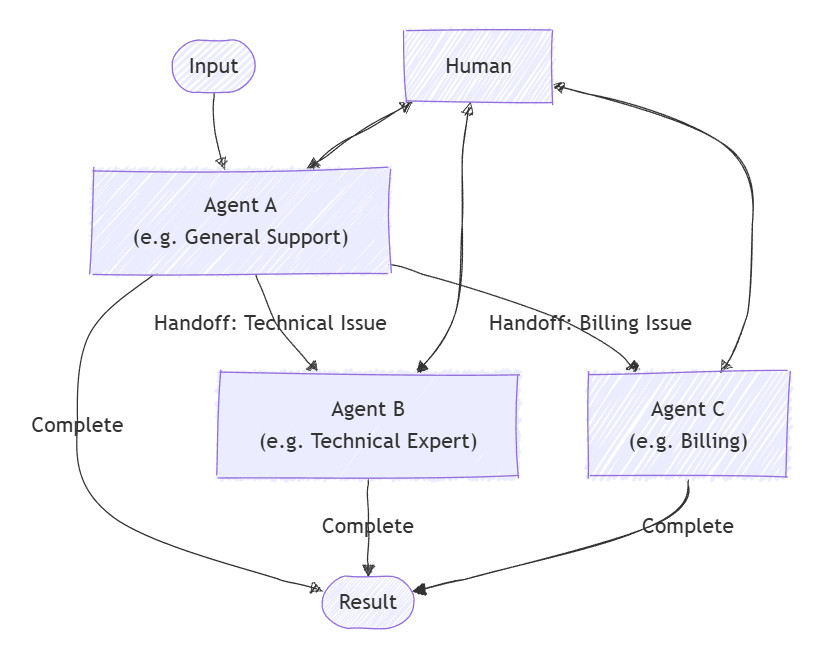


Let's start by defining some tools:

In [58]:
using System;
using System.Collections.Generic;
using System.Threading.Tasks;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.AzureOpenAI;
using System.ComponentModel;

// Define a simplified Customer Support system with specialized tools

// Technical Support Tool - simplified
public class TechnicalSupportTool
{
    // Storage for common technical issues and their solutions
    private Dictionary<string, string> techIssues = new Dictionary<string, string>(StringComparer.OrdinalIgnoreCase) 
    { 
        { "wifi", "1. Restart your router\n2. Check if the cables are properly connected\n3. Reset your network settings" },
        { "slow internet", "1. Check your internet plan bandwidth\n2. Run a speed test\n3. Try connecting via ethernet cable" },
        { "blue screen", "1. Note the error code\n2. Check for Windows updates\n3. Run system diagnostics" },
        { "outlook", "1. Check your internet connection\n2. Verify your password\n3. Clear the Outlook cache" }
    };

    [KernelFunction, Description("Get troubleshooting steps for a technical issue")]
    public string GetTroubleshooting(string issue)
    {
        foreach (var key in techIssues.Keys)
        {
            if (issue.Contains(key, StringComparison.OrdinalIgnoreCase))
                return $"For issues with {key}, try these steps:\n{techIssues[key]}";
        }
            
        return $"I don't have specific troubleshooting steps for '{issue}'. Common issues I can help with include: {string.Join(", ", techIssues.Keys)}";
    }
    
    [KernelFunction, Description("List all available troubleshooting guides")]
    public string ListAllGuides()
    {
        var result = "Available troubleshooting guides:";
        foreach (var issue in techIssues.Keys)
            result += $"\n- {issue}";
        return result;
    }
}

// Billing Tool - simplified
public class BillingTool
{
    // Format: Service name -> (Monthly cost, Renewal date)
    private Dictionary<string, (decimal MonthlyCost, int RenewalDay)> services = 
        new Dictionary<string, (decimal, int)>(StringComparer.OrdinalIgnoreCase)
    {
        { "standard plan", (9.99m, 15) },
        { "premium plan", (19.99m, 20) },
        { "enterprise plan", (49.99m, 1) }
    };
    
    [KernelFunction, Description("Get billing details for a service plan")]
    public string GetPlanDetails(string plan)
    {
        if (string.IsNullOrEmpty(plan) || !services.ContainsKey(plan))
            return $"Plan not found. Available plans: {string.Join(", ", services.Keys)}";
            
        var (cost, renewalDay) = services[plan];
        
        return $"The {plan} costs ${cost:F2} per month and renews on day {renewalDay} of each month.";
    }
    
    [KernelFunction, Description("List all service plans and their costs")]
    public string ListAllPlans()
    {
        var result = "Available service plans:";
        foreach (var plan in services.Keys)
        {
            var (cost, renewalDay) = services[plan];
            result += $"\n- {plan}: ${cost:F2}/month (renews day {renewalDay})";
        }
                
        return result;
    }
}

### Exercise: Add Sub Agents as Plugins to the Orchastrator Agent
Now we create specialized agents and give them the tool they need to perform their operations.

In [ ]:
// Define a plugin class with functions for agent invocation
public class AgentPlugin
{
    // Dictionary to store specialized agents by name
    private Dictionary<string, ChatCompletionAgent> _agents = new();
    
    // Register an agent with this plugin
    public void RegisterAgent(string name, ChatCompletionAgent agent)
    {
        _agents[name] = agent;
    }
    
    // Function to invoke the technical support expert
    [KernelFunction, Description("Ask the technical support expert about troubleshooting issues")]
    public async Task<string> AskTechnicalExpert(string question)
    {
        return await InvokeAgentAsync("TechnicalExpert", question);
    }
    
    // Function to invoke the billing expert
    [KernelFunction, Description("Ask the billing expert about service plans and costs")]
    public async Task<string> AskBillingExpert(string question)
    {
        return await InvokeAgentAsync("BillingExpert", question);
    }
    
    // Helper method to invoke any agent by name
    private async Task<string> InvokeAgentAsync(string agentName, string question)
    {
        if (!_agents.ContainsKey(agentName))
            return $"Agent '{agentName}' not found.";
        
        var agent = _agents[agentName];
        
        // Create a chat history with the user's question
        var chatHistory = new ChatHistory();
        chatHistory.AddUserMessage(question);
        
        // Build the response from the agent
        var responseBuilder = new System.Text.StringBuilder();
        await foreach (var item in agent.InvokeAsync(chatHistory))
        {
            if (item.Message is ChatMessageContent content)
            {
                responseBuilder.Append(content.Content);
            }
        }
        
        return responseBuilder.ToString();
    }
}

// Create and configure the agents with specialized tools
async Task<ChatCompletionAgent> DemoHandoffOrchestration()
{
    // Create technical support expert agent with troubleshooting tool
    var technicalAgent = new ChatCompletionAgent
    {
        Kernel = kernel.Clone(),
        Name = "TechnicalExpert",
        Instructions = @"You are a technical support expert in a customer service system.
            Use your tools to provide accurate troubleshooting steps for common technical issues.
            Only answer questions about technical problems and refer other topics to the appropriate expert."
    };
    technicalAgent.Kernel.ImportPluginFromObject(new TechnicalSupportTool(), "support");
    
    // Create billing expert agent with billing tool
    var billingAgent = new ChatCompletionAgent
    {
        Kernel = kernel.Clone(),
        Name = "BillingExpert",
        Instructions = @"You are a billing specialist in a customer service system.
            Use your tools to provide information about service plans, costs and renewal dates.
            Only answer questions about billing and refer other topics to the appropriate expert."
    };
    billingAgent.Kernel.ImportPluginFromObject(new BillingTool(), "billing");
    
    // TODO: Create the agent plugin and register our specialized _agents
    
    // TODO: Create orchestrator agent with its own kernel
    
    // TODO: Register the agent plugin with the orchestrator's kernel

    var orchestrator = new ChatCompletionAgent
    {
        Kernel = orchestratorKernel,
        Name = "Orchestrator",
        Instructions = $@"You are a customer service coordinator that routes questions to specialized experts.
            
            Available experts:
            - Ask the technical expert using experts.AskTechnicalExpert for questions about troubleshooting, technical issues, wifi problems, etc.
            - Ask the billing expert using experts.AskBillingExpert for questions about service plans, costs, renewal dates, etc.
            
            For each question:
            1. Identify which expert should handle it
            2. Use the appropriate expert function with the original question
            3. Return the expert's response
            
            Do not try to answer questions yourself - always use the appropriate expert."
    };
    
    return orchestrator;
}

<details>
<summary>Click to see solution</summary>

```c#
    // Create the agent plugin and register our specialized agents
    var agentPlugin = new AgentPlugin();
    agentPlugin.RegisterAgent("TechnicalExpert", technicalAgent);
    agentPlugin.RegisterAgent("BillingExpert", billingAgent);
    
    // Create orchestrator agent with its own kernel
    var orchestratorKernel = kernel.Clone();
    
    // Register the agent plugin with the orchestrator's kernel
    orchestratorKernel.ImportPluginFromObject(agentPlugin, "experts");
```
</details>

In [61]:
// Create the orchestrator
var orchestrator = await DemoHandoffOrchestration();

// Define a helper function to process questions through the orchestrator
async Task ProcessQuestion(ChatCompletionAgent agent, string question)
{
    Console.WriteLine($"User Question: {question}\n");
    
    // Create a fresh chat history for this question
    var chatHistory = new ChatHistory();
    chatHistory.AddUserMessage(question);
    
    // Get orchestrator's response (which will invoke the appropriate subagent)
    string response = "";
    await foreach (var item in agent.InvokeAsync(chatHistory))
    {
        if (item.Message is ChatMessageContent content)
        {
            response += content.Content;
        }
    }
    
    Console.WriteLine($"Orchestrator Response: {response}");
    Console.WriteLine(new string('-', 50) + "\n");
}

// Process a set of questions
var questions = new List<string>
{
    "I'm having trouble with my WiFi connection. What should I do?",
    "How much does the premium plan cost?",
    "My computer keeps showing a blue screen. Can you help me troubleshoot?",
    "When does my standard plan subscription renew each month?"
};

// Process each question
foreach (var question in questions)
{
    await ProcessQuestion(orchestrator, question);
}

User Question: I'm having trouble with my WiFi connection. What should I do?

Orchestrator Response: @experts.AskTechnicalExpert I’m having trouble with my WiFi connection. What should I do?
--------------------------------------------------

User Question: How much does the premium plan cost?

Orchestrator Response: @experts.AaskBillingExpert How much does the premium plan cost?
--------------------------------------------------

User Question: My computer keeps showing a blue screen. Can you help me troubleshoot?

Orchestrator Response: <assistant to="experts.AskTechnicalExpert">
My computer keeps showing a blue screen. Can you help me troubleshoot?
</assistant>
--------------------------------------------------

User Question: When does my standard plan subscription renew each month?

Orchestrator Response: {{experts.AaskBillingExpert("When does my standard plan subscription renew each month?")}}
--------------------------------------------------

